# NPxZxD chemostat model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:


In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra as phydra

In [3]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [4]:
from phydra.processes.main import Grid0D, Boundary0D
from phydra.processes.components import Component, Time, make_Component
from phydra.processes.environments import Chemostat
from phydra.processes.fluxes import (LimitedGrowth_Monod, HollingTypeIII, 
                                     make_flux, make_multigrazing)
from phydra.processes.forcingfluxes import (LinearMortalityClosure, QuadraticMortalityClosure, N0_inflow, Outflow, make_FX_flux)
from phydra.processes.forcing import (ConstantN0, ConstantFlow)
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve, InheritGekkoContext

In [5]:
from phydra.processes.forcing import NutrientForcing, MLDForcing

In [6]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.79.g6454bc4.dirty


In [9]:
model = xs.Model({
    'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 
    
    'context':GekkoContext,
                  
    'N':make_Component('Nutrient','N'), 'P':make_Component('Phytoplankton','P'),
    'Z':make_Component('Zooplankton','Z'), #'D':make_Component('Detritus','D'), 
    'Env':Chemostat, 
    
    # Fluxes
    'P_Growth':make_flux(LimitedGrowth_Monod, 'G'), 
     
    'P_LinMortality':make_FX_flux(LinearMortalityClosure, 'P'),
    
    'Grazing':make_multigrazing(HollingTypeIII, 'X'), 
    
    # Closure (i.e. output from system)
    'Z_QuadMortality':make_FX_flux(QuadraticMortalityClosure, 'Z'),
    
    # ForcingFluxes
    'N0_influx':make_FX_flux(N0_inflow, 'W'),
    'Outflux':make_FX_flux(Outflow, 'O'),
    
    'N0':ConstantN0,
    'Flow':ConstantFlow,
    
    'solver':GekkoSolve
})

model

<xsimlab.Model (17 processes, 28 inputs)>
context
time
    days               [in] ('time',) time in days
grid
    shape              [in]
    length             [in]
ibcs
    ibc                [in] Initial Boundary Conditions
N
    init               [in]
    dim                [in]
P
    init               [in]
    dim                [in]
Z
    dim                [in]
    init               [in]
P_Growth
    halfsat_min        [in] half-saturation constant of nutrient up...
    mu_min             [in] Maximum growth rate of component
    R_label            [in] label of ressource component that is co...
    halfsat_max        [in] half-saturation constant of nutrient up...
    C_label            [in] label of component that grows
    mu_max             [in] Maximum growth rate of component
Grazing
    R_label            [in] labels of components that is grazed upon
    Imax               [in] maximum grazing rate for consumer
    C_label            [in] label of component that graze

In [10]:
model.index_vars 


[('time', 'time'),
 ('N', 'N'),
 ('P', 'P'),
 ('Z', 'Z'),
 ('Env', 'components'),
 ('Env', 'fluxes'),
 ('Env', 'forcingfluxes'),
 ('Env', 'forcings'),
 ('P_Growth', 'G'),
 ('P_LinMortality', 'P'),
 ('Grazing', 'X'),
 ('Z_QuadMortality', 'Z'),
 ('N0_influx', 'W'),
 ('Outflux', 'O')]

In [25]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 160)), #365*
        
        'N':{'dim':1,'init':.1}, 
        'P':{'dim':3,'init':.5/2},
        'Z':{'dim':3,'init':0.1},
        
     'P_Growth':{'mu_min':0.7,
                   'mu_max':0.73,
               'halfsat_min':0.67,
               'halfsat_max':0.7,
               'R_label':'N',
               'C_label':'P'
                   
                #'kw':0.04,
                #'kc':0.03,
                #'OptI':30
                   },
        
        'Grazing':{'Imax':.5,
               'halfsat':1.,
               'R_label':'P',
               'C_label':'Z'},
        
                
        'P_LinMortality':{'mortality_rate':0.1,
               'C_labels':['P']},
        
        'Z_QuadMortality':{'mortality_rate':0.1,
               'C_labels':['Z']},
        
        'N0_influx__C_labels':['N'],
        'Outflux__C_labels':['N'],#,'P','Z'],
        
        'Flow__value':0.1,
        'N0__value':2.5,

    },
    output_vars={
        'Env__comp_output':None,
        'Env__flux_output':None,
        'Env__fxflux_output':None,
        'Env__forcing_output':None
    }
                 )

In [26]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Gekko Context
Initializing Model Time
dimensions of component N are initialized at 1
Initializing component  N ['N']
dimensions of component P are initialized at 3
Initializing component  P ['P-0', 'P-1', 'P-2']
dimensions of component Z are initialized at 3
Initializing component  Z ['Z-0', 'Z-1', 'Z-2']
flux P_Growth is initialized for N --> P
setup_dims (1, 3) P mu
[[0.7   0.715 0.73 ]]
setup_dims (1, 3) P halfsat_Growth
[[0.67  0.685 0.7  ]]
Initializing flux: P_Growth-N2P
flux Grazing is initialized for P --> Z
setup_dims (3, 3) Grazing-P2Z GrazePreference
setup_dims (3, 3) Grazing-P2Z FoodAvailability
setup_dims (3, 3) Grazing-P2Z BiomassGrazed
MATRIX [[1 1 1]
 [1 1 1]
 [1 1 1]]
MATRIX [[1 1 1]
 [1 1 1]
 [1 1 1]]
MATRIX [[1 1 1]
 [1 1 1]
 [1 1 1]]
MATRIX [[1 1 1]
 [1 1 1]
 [1 1 1]]
MATRIX [[1 1 1]
 [1 1 1]
 [1 1 1]]
MATRIX [[1 1 1]
 [1 1 1]
 [1 1 1]]
MATRIX [[1 1 1]
 [1 1 1]
 [1 1 1]]
MATRIX [[1 1 1]
 [1 1 1]
 [1 1 1]]
MATRIX [[1 1 1]
 [1 1 1]
 [1 1 1]]
Total Grazed 

Exception: @error: Solution Not Found


In [ ]:
out_ds

In [ ]:
out_ds.Env__comp_output.plot.line(x='time', ylim=0)#, ylim=(0,2.5))  # (0,2.5)
#out_ds.Env__comp_output.isel(components=slice(1,-1)).sum(axis=0).plot.line(x='time')

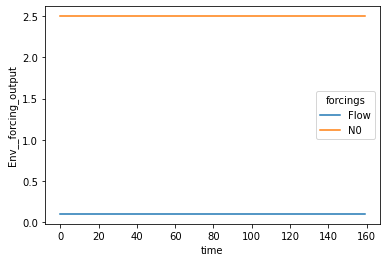

In [23]:
out_ds.Env__forcing_output.plot.line(x='time')

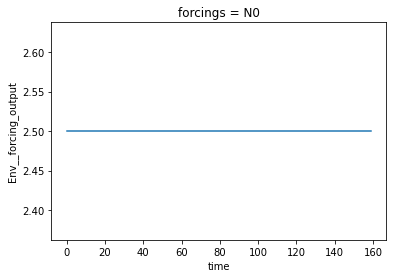

In [24]:
out_ds.Env__forcing_output.sel(forcings='N0').plot(x='time')  #, time=np.arange(300,400)

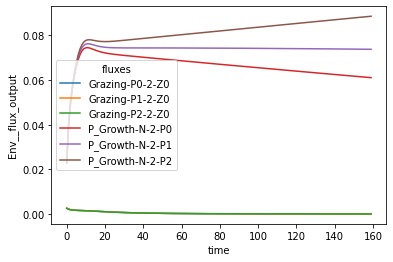

In [25]:
out_ds.Env__flux_output.plot.line(x='time')

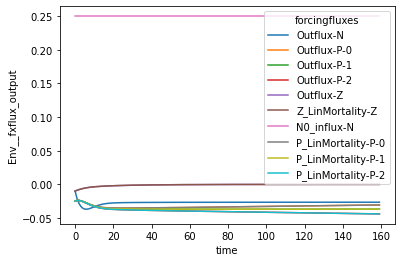

In [26]:
out_ds.Env__fxflux_output.plot.line(x='time')